In [1]:
import matplotlib.pyplot as plt 
import scipy
from scipy import stats
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import os


import prop_data_prep as pdp
import prop_nn_models as pnn
import prop_MCDO_functions as MCDO

# TO-DO
#   - [ ] plot to check if properly scaled (d, t, d/t)
# (!) plot loss over epoch; plot timeseries of all data preditions and all of data (y_test, y_prediction)
# prediciton heatmap (spatial distribution)
# figure out what x and y to give from bortnik - add as input to 1-hr time series
# technicallu b2016 uses r-xyz and lshell

# TO-DO
# BASIC NN
# [x] Clean dataset (nans, inteprolation)
# [x] Establish train / val/ test set (~60%/20%/20%)
# [x] Hyperparameter optimization (nodes, hidden layers, loss function, etc.)
# [ ] Retrain model and report accuracy 

# RECREATE BORTNIKS RESULTS
# [ ] Ion density - Does the model capture plasamspheric plume?
# CREATE MMS RESULTS
# [ ] E = - V X B
# amrcaspi


In [2]:
# df['BZ'].isna().sum()

In [3]:
# preserve randomness for code reporducability by introducing random seed 
#   - source: https://tinyurl.com/2ffnsfvb
seed=42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# (!) when running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# set a fixed value for the hash seed
os.environ["PYTHONHASHSEED"] = str(seed)
print(f"Random seed set as {seed}")

# data check
df_ds = pdp.df_ds
df_ds.head(5)

Random seed set as 42


,1-M_AE_nT,SYM/H_INDEX_nT,1-M_PC(N)-INDEX_,T,n,VX,VY,VZ,BX,BY,BZ,X,Y,Z,EX,EY,EZ
time,,,,,,,,,,,,,,,,,
2017-11-01 03:24:00+00:00,30,0,0.17,42.206993,9.359701,-277.564360,20.120346,2.889945,1.694486,-2.616403,1.122636,10.152656,19.320639,4.893302,-30.149096,-316.500827,-692.126644
2017-11-01 03:25:00+00:00,32,0,0.19,41.336135,9.328363,-277.367658,22.849964,3.101512,1.644581,-2.684033,1.005360,10.151889,19.325139,4.894869,-31.297004,-283.955076,-706.885264
2017-11-01 03:26:00+00:00,31,0,0.20,39.210209,9.396939,-277.332465,23.102912,3.866655,1.650214,-2.626818,1.078423,10.150556,19.332933,4.897585,-35.071709,-305.462477,-690.377300
2017-11-01 03:27:00+00:00,31,0,0.19,41.644468,9.407722,-277.169238,23.035629,4.275142,1.641951,-2.554054,1.208827,10.149166,19.341017,4.900402,-38.765035,-342.069255,-670.081845
2017-11-01 03:28:00+00:00,30,0,0.21,40.253720,9.404135,-277.135414,22.441875,3.752938,1.682309,-2.543731,1.182767,10.147772,19.349091,4.903217,-36.089968,-334.100126,-667.203899


In [4]:
# mms_dataset = pdp.dat_mms1                  # dataset containing EF [xarray]
# m = pdp.write_toDf(mms_dataset['time'], 
#                    mms_dataset['Dst'], 
#                    mms_dataset['L'], 
#                    mms_dataset['MLAT'], 
#                    mms_dataset['Scpot'],
#                    mms_dataset['E_DIS'], 
#                    mms_dataset['E_EDI'])
# edix = m['E_EDI_X']
# disx = m['E_DIS_X']
# m['EX'] = m['E_EDI_X'].combine_first(m['E_DIS_X'])
# m['EY'] = m['E_EDI_Y'].combine_first(m['E_DIS_Y'])
# m['EZ'] = m['E_EDI_Z'].combine_first(m['E_DIS_Z'])
# m.head(5)


In [5]:
# # define target and predictions variables

# mms test data (from Andy)
predictors = ['SYM/H_INDEX_nT', 'X', 'Y', 'Z']
target = ['EX','EY','EZ'] 

# split dataset into predictors (x) and target (y)
x = df_ds[predictors].values

if len(target) > 1:
    y = df_ds[target].values
else:
    y = df_ds[target].values.reshape(-1, 1) # for one target 

# # mms test data (from Matt)
# predictors = ['Dst', 'L', 'MLAT', 'Scpot']
# target = ['EX','EY','EZ']

# m.dropna(inplace=True)
# m2 = m.iloc[:60000]


# # split dataset into predictors (x) and target (y)
# x = m2[predictors].values

# if len(target) > 1:
#     y = m2[target].values
# else:
#     y = m2[target].values.reshape(-1, 1) # for one target 


# scaling the dataset
# - (?) scale y?
# - (!) consider min/max scaler (see that one article)
x_scaler = StandardScaler()
x_scaler.fit(x)
x_scaled = x_scaler.transform(x)
y_scaler = StandardScaler()
y_scaler.fit(y)
y_scaled = y_scaler.transform(y)

seq_len = 60
x_scaled3d, y_scaled3d = pdp.prepare_3Darrs(x_scaled,y_scaled,lag=seq_len,delay=1,next_steps=1)

# define train and test sets
#   - (!) always shuffling to best avoid cross-sampling
x_train, x_test, y_train, y_test = train_test_split(x_scaled3d, y_scaled3d, test_size=0.3, random_state=seed, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=seed, shuffle=True) # test/validation set

# covert data to torch tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test)
x_val_tensor = torch.Tensor(x_val)
y_val_tensor = torch.Tensor(y_val)

In [6]:
# (!) optuna - loss func, inputs + trials
# hyperparameters [model creation]
num_features = len(predictors)  # no. of input features/variables
hidden_size = [50, 30, 15]      # no. of nuerons in hidden layer ;experiment
output_size = len(target)       # predicting n vars where n = len(target) array
learning_rate = 0.001           # learning rate
seq_len_model = seq_len         # sequence length
dropout_prob = 0.2              # dropout probability

# hyperparameters [for training]
num_epochs = 150                # number of epochs (passes) through training dataset
patience = 20                   # hyperparameter for early-stopping to prevent overfitting

# initialize the model
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = pnn.FeedForwardNN_MCDO(num_features, seq_len_model, hidden_size, output_size, dropout_prob)

# define loss function and optimizer
criterion = nn.MSELoss()  # mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

# check that model is properly initialized
print(f'Predictor(s): {predictors}, Target(s): {target}')
print( model )

bsize = 32 # batch size

# training data loading
train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=bsize, shuffle=True)

# validation data loading
val_data = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=bsize, shuffle=True)

# check
print( x_train_tensor.shape, y_train_tensor.shape )
print( model(x_train_tensor).shape )

Predictor(s): ['SYM/H_INDEX_nT', 'X', 'Y', 'Z'], Target(s): ['EX', 'EY', 'EZ']
FeedForwardNN_MCDO(
  (layers): Sequential(
    (0): Linear(in_features=240, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=30, out_features=15, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=15, out_features=3, bias=True)
  )
)
torch.Size([24551, 60, 4]) torch.Size([24551, 1, 3])
torch.Size([24551, 3])


Epoch [1/500], Test Loss: 0.8957, Validation Loss: 0.8148
Epoch [2/500], Test Loss: 0.8261, Validation Loss: 0.7532
Epoch [3/500], Test Loss: 0.7957, Validation Loss: 0.7290
Epoch [4/500], Test Loss: 0.7767, Validation Loss: 0.7301
Epoch [5/500], Test Loss: 0.7654, Validation Loss: 0.7284
Epoch [6/500], Test Loss: 0.7560, Validation Loss: 0.6803
Epoch [7/500], Test Loss: 0.7437, Validation Loss: 0.6869
Epoch [8/500], Test Loss: 0.7382, Validation Loss: 0.6638
Epoch [9/500], Test Loss: 0.7300, Validation Loss: 0.6797
Epoch [10/500], Test Loss: 0.7266, Validation Loss: 0.6774
Epoch [11/500], Test Loss: 0.7236, Validation Loss: 0.6682
Epoch [12/500], Test Loss: 0.7216, Validation Loss: 0.6491
Epoch [13/500], Test Loss: 0.7084, Validation Loss: 0.6369
Epoch [14/500], Test Loss: 0.7073, Validation Loss: 0.6340
Epoch [15/500], Test Loss: 0.7133, Validation Loss: 0.6304
Epoch [16/500], Test Loss: 0.7105, Validation Loss: 0.6245
Epoch [17/500], Test Loss: 0.7103, Validation Loss: 0.6582
Epoch 

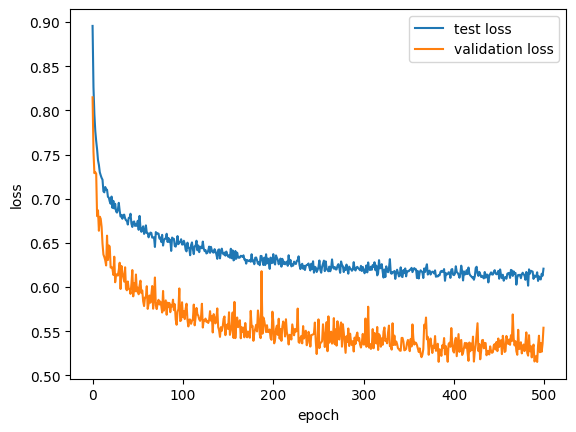

In [7]:
# train the model
test_loss = [] # list to hold loss values over epoch
val_loss = []


for epoch in range(num_epochs):
    model.train() # turn on training mode
    loss_sum = 0
    v_loss_sum = 0
    
    # (1) training
    for inputs, targets in train_loader:
        # forward pass
        outputs = model(inputs)

        # loss
        loss = criterion(outputs, targets[:,0,:])
        loss_sum += loss.item()#/len(inputs)

        # back pass and optimization
        optimizer.zero_grad() 
        loss.backward()  # compute gradients
        optimizer.step()  # update weights

    # progress, computing test loss
    loss_sum = loss_sum/len(train_loader)
    test_loss.append(loss_sum)

    # (2) validation
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            # forward pass
            outputs = model(inputs)

            # loss
            v_loss = criterion(outputs, targets[:,0,:])
            v_loss_sum += v_loss.item()

        # compute validation loss
        v_loss_sum = v_loss_sum/len(val_loader)
        val_loss.append(v_loss_sum)

    # (3) implement stop function
    # check if train loss has increase since last time
    latest_train_loss = val_loss[-2] if epoch > 1 else np.inf
    if v_loss_sum > latest_train_loss:
        patience -= 1
    # reset to initial patience when model improves
    else:
        patience = 20
    # break out if patience reached
    if patience == 0:
        print(f'Patience reached at epoch {epoch}; stopping training...')
        break


    # status check
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {loss_sum:.4f}, Validation Loss: {v_loss_sum:.4f}')

fig, ax = plt.subplots(1)
ax.plot(np.arange(epoch+1), test_loss, label="test loss")
ax.plot(np.arange(epoch+1), val_loss, label="validation loss")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()


In [8]:
# evaluate on the test set (no MC dropout)
# set model to evaluation mode and deactivate autogradient engine
model.eval() 
with torch.no_grad():
    predictions = model(x_test_tensor).detach().numpy()

    for i in range(output_size):
        rmse = MCDO.rmse(y_test[:,0,i], predictions[:,i])
        print(f'RMSE for {target[i]}: {rmse:.4f}')


    # test_loss = criterion(preds, y_test_tensor) # give in same batch size as training?
    # print(f'Test Loss: {test_loss.item():.4f}')

RMSE for EX: 0.7617
RMSE for EY: 0.7901
RMSE for EZ: 0.7210


In [9]:
# plot results


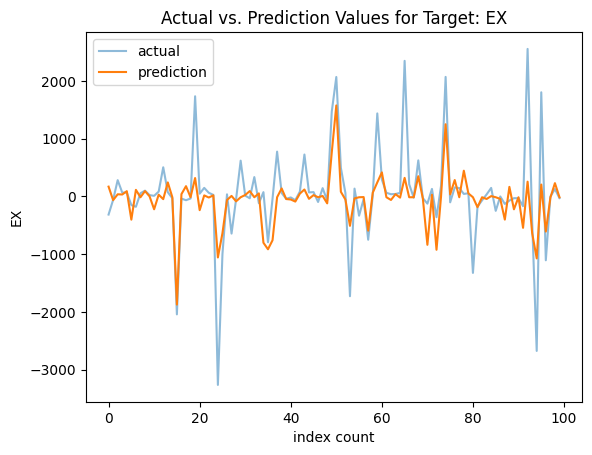

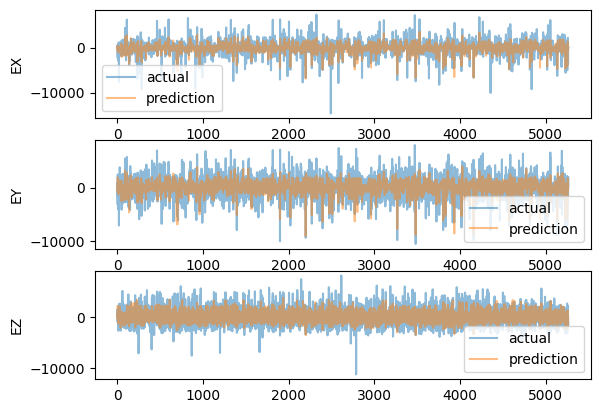

In [15]:
# # plot results
# preds = model(x_test_tensor).detach().numpy()

model.eval() 
with torch.no_grad():

    preds = model(x_test_tensor).detach().numpy()
    preds_descaled = y_scaler.inverse_transform(preds)
    y_test_descaled = y_scaler.inverse_transform( y_test[:,-1,:] )

    y_out_inv = y_scaler.inverse_transform(preds)
    y_test_inv = y_scaler.inverse_transform(y_test[:,0])

    # for scaling
    ia = 1000
    ib = 1100

    # plot sing target 
    plt.plot(y_test_inv[:,0][ia:ib],alpha=0.5, label='actual')
    plt.plot(preds_descaled[:,0][ia:ib], label='prediction')
    plt.title(f'Actual vs. Prediction Values for Target: {target[0]}')
    plt.xlabel(f'index count')
    plt.ylabel(f'{target[0]}')
    plt.legend()
    plt.show()
    plt.close()

    # plot all targets
    fig, axes = plt.subplots(len(target), 1)
    for i in range(len(target)):
        axes[i].plot( y_test_descaled[:,i], alpha=0.5, label='actual' )
        axes[i].plot( preds_descaled[:,i], alpha=0.5, label='prediction' )
        axes[i].set_ylabel(target[i])
        axes[i].legend()


RMSE for EX: (no MCDO) 0.7617, (with MCDO) 0.7664
RMSE for EY: (no MCDO) 0.7901, (with MCDO) 0.7914
RMSE for EZ: (no MCDO) 0.7210, (with MCDO) 0.7172


(5262, 1, 3)

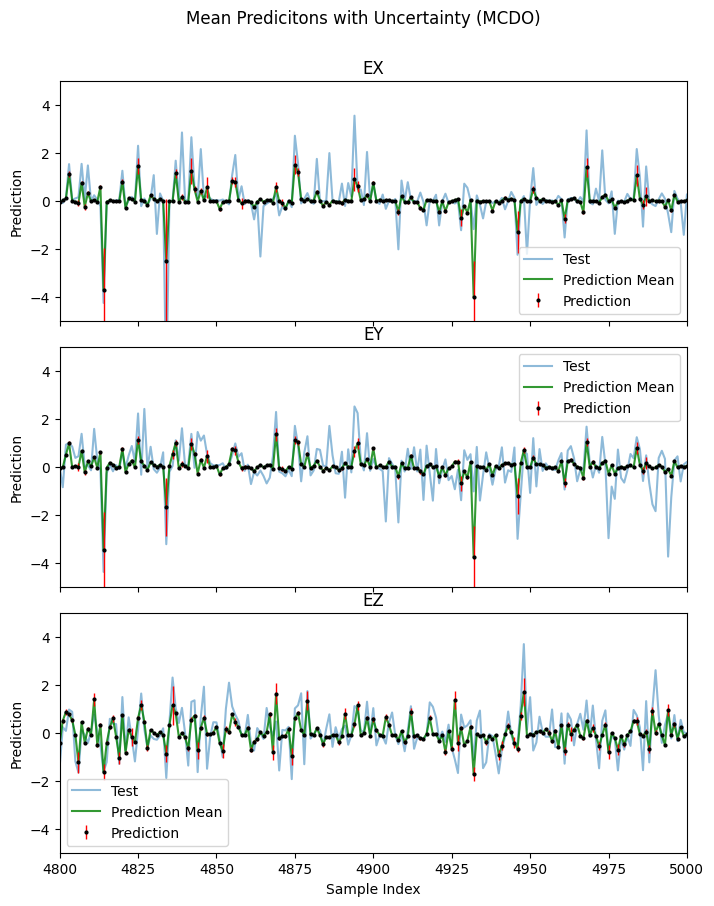

In [11]:

# iterate MC dropout over defined number of samples to get distribution of error

num_passes = 100                        # number of monte-carlo passes to generate
num_samples = len(model(x_test_tensor)) # number of samples in each target
num_targets = output_size               # number of target variables in dataset

dropout_predictions, pred_mean, pred_stdev = MCDO.get_MCDO_predictions(model, x_test_tensor, num_passes, num_samples, num_targets)

# plot results
fig, axes = plt.subplots(len(target), 1, sharex=True, figsize=(7, 9))
fig.tight_layout()

# plot scaling
ia = 4800
ib = 5000
ic = 5

fig.suptitle('Mean Predicitons with Uncertainty (MCDO)')
plt.subplots_adjust(top=0.90)
for i in range(len(target)):
    axes[i].plot( y_test[:,-1,i], alpha=0.5, label='Test' )  # plot test
    axes[i].plot( pred_mean[:,i], alpha=0.8, label='Prediction Mean', c='g' )  # plot pred mean
    axes[i].errorbar(range(len(pred_mean[:,i])), pred_mean[:,i], yerr=pred_stdev[:,i], 
                     c = 'r', # line color
                     mfc = 'k', # marker face color
                     mec = 'k', # marker edge color
                     fmt='o', 
                     lw = 1,
                     markersize=2, label='Prediction')
    axes[i].set_ylabel('Prediction')
    axes[i].set_title(f"{target[i]}")
    axes[i].legend()
    axes[i].set_xlim(ia,ib)
    axes[i].set_ylim(-ic, ic)
axes[len(target)-1].set_xlabel('Sample Index')

# compare with predictions with/without MCDO
for i in range(output_size):
    rmse = MCDO.rmse(y_test[:,0,i], predictions[:,i])
    rmse_MCDO = MCDO.rmse(y_test[:,0,i], pred_mean[:,i])
    print(f'RMSE for {target[i]}: (no MCDO) {rmse:.4f}, (with MCDO) {rmse_MCDO:.4f}')

# check
y_test.shape

dimension: 12.652365733566105
dimension: 6.489485737935129
dimension: 7.690748298228581


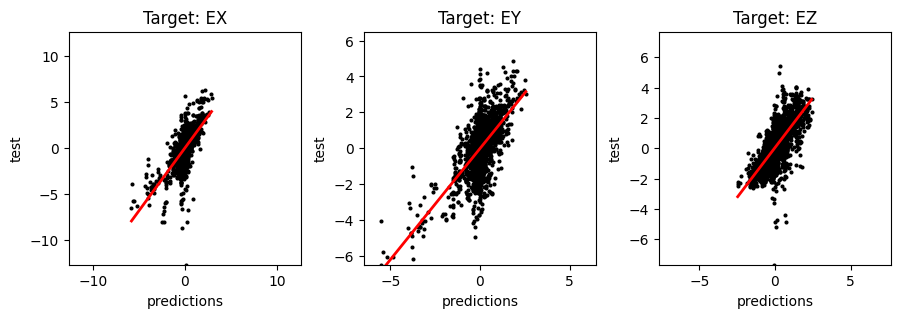

In [12]:
def perfect_axis(ax, x, y):
    plot_dim = max([max(x),
                    max(y),
                    abs(min(x)),
                    abs(min(y))])
    print(f'dimension: {plot_dim}')
    ax.set_xlim([-plot_dim, plot_dim])
    ax.set_ylim([-plot_dim, plot_dim])
    ax.set_aspect('equal')

# # single plot example
# fig, ax = plt.subplots()
# px = predictions[:,0]
# py = test[:,0,1]
# ax.scatter(px, py, c='k', marker=".", s=15, alpha=1)
# ax.set_xlabel('predictions')
# ax.set_ylabel('test')

# # polyfit line
# #   - np.unique(x) handles case for unsorted or duplicate x values
# ax.plot(np.unique(px), np.poly1d(np.polyfit(px, py, 1))(np.unique(px)), c='r', linewidth=2)
# perfect_axis(ax, px, py)

# # plt.axis('square')
# # ---

# multiple targets
fig, axes = plt.subplots(1, len(target), figsize=(9, 8))
fig.tight_layout()
for i in range(len(target)):
    px = pred_mean[:,i]
    py = y_test[:,0,i]
    axes[i].scatter(px, py, c='k', marker=".", s=15, alpha=1)
    axes[i].set_title(f'Target: {target[i]}')
    axes[i].set_xlabel('predictions')
    axes[i].set_ylabel('test')
    axes[i].plot(np.unique(px), np.poly1d(np.polyfit(px, py, 1))(np.unique(px)), c='r', linewidth=2)
    perfect_axis(axes[i], px, py)

In [13]:
# # evaluate on the test set (with MC dropout)
# with torch.no_grad():
#     model.eval() # set model to evaluation mode
#     num_samples = 100  # no. of samples to generate
    
#     predictions = []
#     for _ in range(num_samples):
#         outputs = model(x_test_tensor)
#         predictions.append(outputs)

#     predictions = torch.cat(predictions, dim=0) # concatenate predictions along the time dimension
#                                                 # (!) CHECK: is 0 the right dimension? (batch dimension?)
#     # mean_prediction = torch.mean(predictions, dim=1)  # mean prediction (for 1 target, maybe?)
#     # prediction_stddev = torch.std(predictions, dim=1)  # standard deviation of predictions (for 1 target, maybe?)
    
#     test_loss = criterion(outputs, y_test_tensor) # give in same batch size as training?
#     print(f'Test Loss: {test_loss.item():.4f}')
   



# # Plot mean predictions and uncertainty for each target

# mean_prediction = torch.mean(predictions, dim=1)  # Mean prediction for target i
# prediction_stddev = torch.std(predictions, dim=1)  # Standard deviation of predictions for target i

# plt.figure(figsize=(10, 6))
# plt.errorbar(range(len(mean_prediction)), mean_prediction.numpy(), yerr=prediction_stddev.numpy(), fmt='o', label=f'Prediction Target {i+1}')
# plt.xlabel('Sample Index')
# # plt.ylabel(f'Prediction Target {i+1}')
# # plt.title(f'Mean Predictions with Uncertainty (Monte Carlo Dropout) for Target {i+1}')
# plt.legend()
# plt.grid(True)
plt.show()

In [14]:
# print(mean_prediction)
# print(prediction_stddev)

# ia = 1000
# ib = 1100

# sliced_mean_prediction = mean_prediction[ia:ib]
# sliced_prediction_stddev = prediction_stddev[ia:ib]

# # Plot mean predictions and uncertainty
# plt.figure(figsize=(10, 6))
# plt.errorbar(range(len(sliced_mean_prediction)), sliced_mean_prediction.numpy(), yerr=sliced_prediction_stddev.numpy(), fmt='o', label='Prediction')
# plt.xlabel('Sample Index')
# plt.ylabel('Prediction')
# plt.title('Mean Predictions with Uncertainty (Monte Carlo Dropout)')
# plt.legend()
# #plt.grid(True)
# plt.show()